In [3]:
# Setup copied from Activity 3
# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# Note: UMAP requires: pip install umap-learn
try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    print("UMAP not available. Install with: pip install umap-learn")
    print("You can skip UMAP and focus on PCA and t-SNE.")
    UMAP_AVAILABLE = False

# Anomaly Detection
from sklearn.ensemble import IsolationForest

# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


# Part 1: Clustering Analysis 

In [14]:
# File read and setup provided in Activity 3 template
df = pd.read_csv('../data/Mall_Customers.csv')
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
display(df.head())

Shape: (200, 5)
Columns: ['CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

First few rows:


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [15]:
# Check data types and missing values
print("Dataset Information:")
df.info()

print("\nMissing values:")
print(df.isnull().sum())

print("\nBasic statistics:")
df.describe()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB

Missing values:
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Basic statistics:


,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [18]:
# preprocessing

# set anual income to thousands
df['Annual Income (k$)'] = df['Annual Income (k$)'] * 1000

# rename columns for easier access
df.columns = ['CustomerID', 'Gender', 'Age', 'AnnualIncome', 'SpendingScore'] 

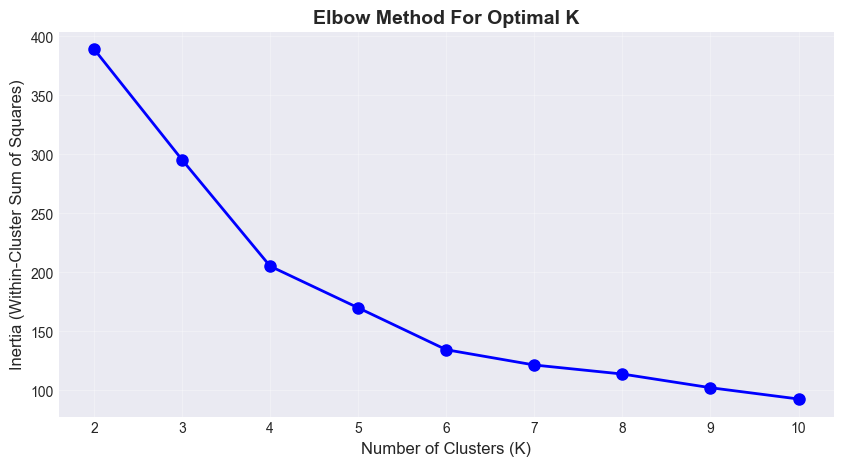


Inertia Values:
K=2: 389.386
K=3: 295.456
K=4: 205.225
K=5: 169.891
K=6: 134.353
K=7: 121.389
K=8: 113.727
K=9: 102.136
K=10: 92.550


In [19]:
# Get features, exclude customer id
feature_cols = ['Age', 'AnnualIncome', 'SpendingScore']
X = df[feature_cols].copy()

# Scale Age, annual income, spending score
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertia_values = []
K_range = range(2, 11)  # K from 2 to 10

for k in K_range:
    inertia = KMeans(n_clusters=k, random_state=42).fit(X_scaled).inertia_
    inertia_values.append(inertia)

# Plot the elbow curve
plt.figure(figsize=(10, 5))
plt.plot(K_range, inertia_values, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
plt.title('Elbow Method For Optimal K', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(K_range)
plt.show()

print("\nInertia Values:")
for k, inertia in zip(K_range, inertia_values):
    print(f"K={k}: {inertia:.3f}")

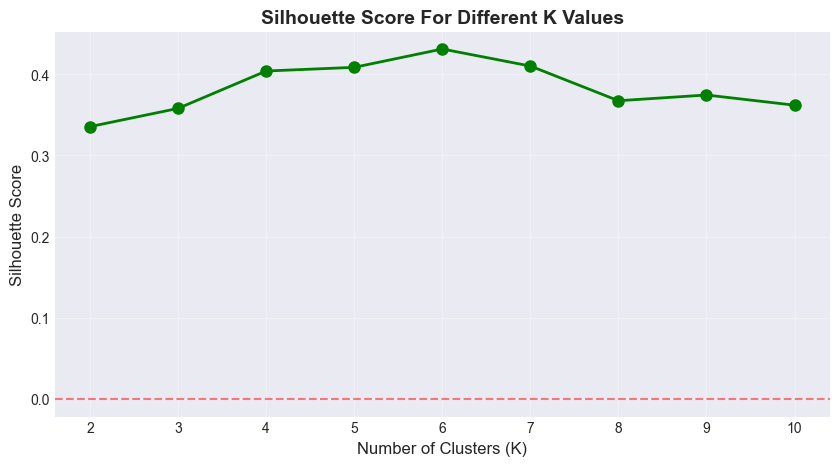


Silhouette Scores:
K=2: 0.335
K=3: 0.358
K=4: 0.404
K=5: 0.408
K=6: 0.431
K=7: 0.410
K=8: 0.367
K=9: 0.374
K=10: 0.362


In [20]:
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# Plot silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score For Different K Values', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(K_range)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.show()

# Print the scores
print("\nSilhouette Scores:")
for k, score in zip(K_range, silhouette_scores):
    print(f"K={k}: {score:.3f}")

## Optimal-K choice:

Our optimal k-choice is 6. Based on the elbow method, K=6 lies near the elbow of the graph where the inertia stops decreasing drastically. The silhouette score at K=6 is also the highest out of all K-values from 2 to 10. This means there are 6 types of customers with specific spending habits. There may also be data errors within those 6 clusters.

In [23]:
# Create the model and determine count in each cluster
optimal_k = 6

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_final.fit(X_scaled)

cluster_labels = kmeans_final.labels_

# Add cluster labels to original dataframe
df['Cluster'] = cluster_labels

print(f"✓ K-Means clustering completed with K={optimal_k}")
print(f"\nCluster distribution:")
print(df['Cluster'].value_counts().sort_index())

✓ K-Means clustering completed with K=6

Cluster distribution:
0    45
1    39
2    25
3    40
4    30
5    21
Name: Cluster, dtype: int64


array([ 303.59677996,  331.46486206,  317.53082101,  359.33294416,
        470.80527257,  345.39890311,  526.54143677,  359.33294416,
        930.62862724,  456.87123152,  972.43075039,  526.54143677,
        847.02438094,  373.26698521,  554.40951887,  345.39890311,
        526.54143677,  317.53082101,  763.42013463,  526.54143677,
        526.54143677,  387.20102627,  679.81588833,  470.80527257,
        791.28821673,  442.93719047,  665.88184728,  526.54143677,
        596.21164202,  359.33294416,  874.89246304,  331.46486206,
        777.35417568,  289.66273891,  721.61801148,  331.46486206,
        624.07972413,  456.87123152,  540.47547782,  317.53082101,
        944.56266829,  373.26698521,  707.68397043,  470.80527257,
        721.61801148,  373.26698521,  735.55205253,  415.06910837,
        442.93719047,  470.80527257,  721.61801148,  498.67335467,
        470.80527257,  860.95842199,  735.55205253,  693.74992938,
        749.48609358, 1000.29883249,  415.06910837,  777.35417

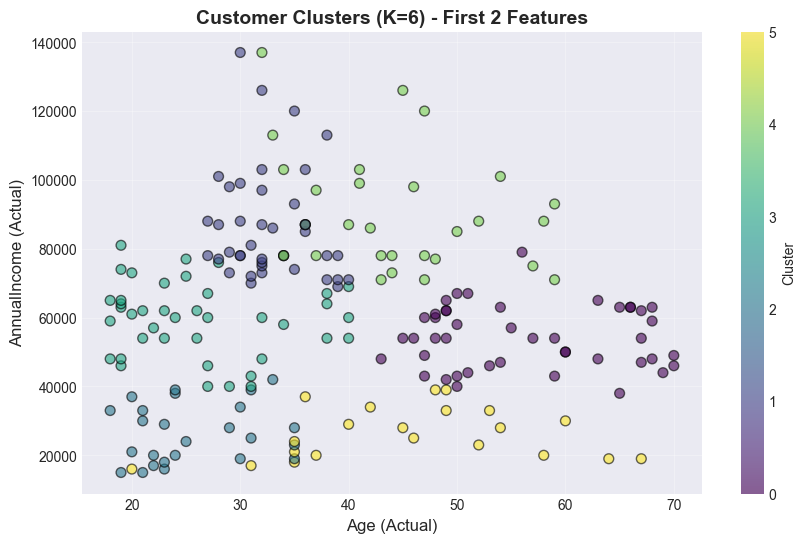

In [ ]:
# Modified visualization helper function from Activity 3 template
def plot_clusters_2d(X, labels, feature_names, title="K-Means Clusters"):
    """
    Plot clusters using first two features.
    """
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(scaler.inverse_transform(X)[:, 0], scaler.inverse_transform(X)[:, 1], c=labels, cmap='viridis',
                         alpha=0.6, edgecolors='k', s=50)
    plt.xlabel(f'{feature_names[0]} (Actual)', fontsize=12)
    plt.ylabel(f'{feature_names[1]} (Actual)', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.colorbar(scatter, label='Cluster')
    plt.grid(True, alpha=0.3)

# Plot clusters
plot_clusters_2d(X_scaled, cluster_labels, feature_cols,
                title=f"Customer Clusters (K={optimal_k}) - First 2 Features")

plt.show()


# Part 2: Dimensionality Reduction

# Part 3: Anomaly Detection

# Part 4: Integrated Analysis